In [1]:
import pandas as pd

In [2]:
sub = pd.read_csv('../input/SampleSubmission.csv')
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train = pd.read_csv('../input/Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [4]:
# This list will be useful later
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [5]:
# Add file names

train['file_name'] = 'train/'+train['ID']+'.png'
sub['file_name'] = 'test/'+sub['ID']+'.png'

In [10]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob('../train/*.png')
print(len(ims), len(train))

1857 1857


In [11]:
# If you stopped the process early and want to try with only a few spectrograms, this will only use the ones that have been generated
# train['img_path'] = train['file_name'].str[:-4]+'.png'
train['img_path'] = '../train\\' + train['ID']+'.png'
train = train.loc[train.img_path.isin(ims)]
len(train)

1857

In [12]:
# Similarly, test now has rows for files that have had spectrograms created.
sub['img_path'] = '../test\\'+sub['ID']+'.png'
ims = glob.glob('../test/*.png')
test = sub.loc[sub.img_path.isin(ims)]
print(len(sub), len(test))

911 911


# Modelling

I use a model pre-trained on imagenet, and throw the spectrograms at it. Not the most elegant approach, but it will do for now!

In [12]:
from fastai.vision import *

In [ ]:
np.random.seed(42)

# tfms = get_transforms()
tfms=[]
data = (ImageList.from_df(train, path='../', cols=2)
      .split_by_rand_pct(.3, seed=42)
      .label_from_df(cols=1)
      .transform(tfms, size=224)
      .databunch(bs=32)
      .normalize(imagenet_stats)
     )

In [ ]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy, top_k_accuracy]).to_fp16().mixup()

In [ ]:
# Train the head of the model
lr = 4e-3
learn.fit_one_cycle(3, lr)

In [ ]:
# Not doing very well yet. Let's train the inner layers
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20, slice(6e-5, 6e-4))

In [ ]:
learn.save('densenet201-mixup-stg1')

In [13]:
np.random.seed(42)

# tfms = get_transforms()
tfms=[]
data = (ImageList.from_df(train, path='../', cols=2)
      .split_by_rand_pct(.3, seed=42)
      .label_from_df(cols=1)
      .transform(tfms, size=512)
      .databunch(bs=12)
      .normalize(imagenet_stats)
     )

In [14]:
learn = cnn_learner(data, models.densenet201, metrics=[error_rate, accuracy, top_k_accuracy]).to_fp16().mixup()

In [ ]:
learn.load('densenet201-mixup-stg1')

In [ ]:
lr = 4e-4
learn.fit_one_cycle(4, lr)

In [ ]:
learn.save('densenet201-mixup-stg2')

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-06


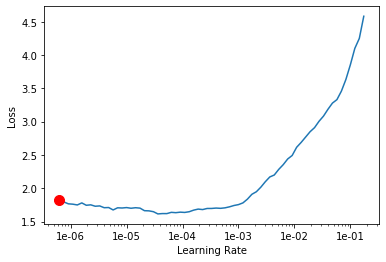

In [16]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(40, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.671305,1.736771,0.432675,0.567325,0.822262,02:32
1,1.690089,1.776915,0.427289,0.572711,0.818671,02:25
2,1.626106,1.770905,0.436266,0.563734,0.825853,02:24
3,1.627037,1.731733,0.421903,0.578097,0.820467,02:25
4,1.692736,1.697921,0.414722,0.585278,0.822262,02:24
5,1.627540,1.672542,0.409336,0.590664,0.827648,02:25
6,1.684035,1.657688,0.400359,0.599641,0.831239,02:24
7,1.533918,1.633768,0.400359,0.599641,0.829443,02:23
8,1.483058,1.639713,0.389587,0.610413,0.836625,02:24
9,1.493459,1.580336,0.380610,0.619390,0.840215,02:25


In [18]:
learn.save('densenet201-mixup-stg2b')

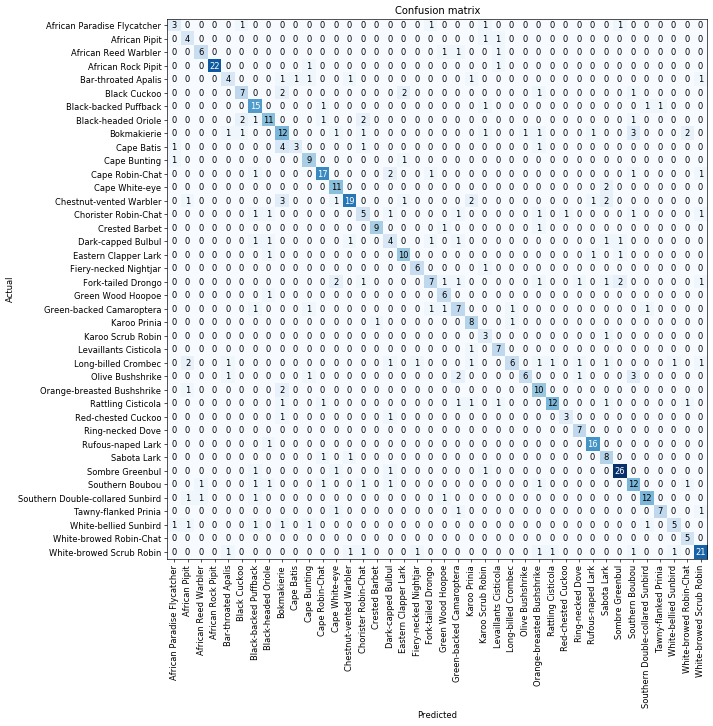

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(min_val=2)

[('Cape Batis', 'Bokmakierie', 4),
 ('Bokmakierie', 'Southern Boubou', 3),
 ('Chestnut-vented Warbler', 'Bokmakierie', 3),
 ('Olive Bushshrike', 'Southern Boubou', 3),
 ('Black Cuckoo', 'Bokmakierie', 2),
 ('Black Cuckoo', 'Eastern Clapper Lark', 2),
 ('Black-headed Oriole', 'Black Cuckoo', 2),
 ('Black-headed Oriole', 'Chorister Robin-Chat', 2),
 ('Bokmakierie', 'White-browed Robin-Chat', 2),
 ('Cape Robin-Chat', 'Dark-capped Bulbul', 2),
 ('Cape White-eye', 'Sabota Lark', 2),
 ('Chestnut-vented Warbler', 'Karoo Prinia', 2),
 ('Chestnut-vented Warbler', 'Sabota Lark', 2),
 ('Fork-tailed Drongo', 'Cape White-eye', 2),
 ('Fork-tailed Drongo', 'Sombre Greenbul', 2),
 ('Long-billed Crombec', 'African Pipit', 2),
 ('Olive Bushshrike', 'Green-backed Camaroptera', 2),
 ('Orange-breasted Bushshrike', 'Bokmakierie', 2)]

# Making a submission

Save the model's predicted probabilities to a file following the sample submission format. This can be submitted on Zindi.

In [21]:
src = (ImageList.from_folder('../test'))

In [22]:
# Add the test data as a test set for the model
learn.data.add_test(src)

In [23]:
# Get predictions
preds, y = learn.get_preds(DatasetType.Test)

In [24]:
test.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_name,img_path
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,test/019OYB.png,test\019OYB.png
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,test/01S9OX.png,test\01S9OX.png
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,test/02CS12.png,test\02CS12.png
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,test/02LM3W.png,test\02LM3W.png
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,test/0C3A2V.png,test\0C3A2V.png


In [25]:
# Add preds to test
test = test.copy()
for b in birds:
  test[b] = preds[:,learn.data.classes.index(b)]
test.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_name,img_path
0,019OYB,0.000155,0.000089,0.000742,0.992805,0.000026,0.000432,0.000118,0.000689,0.000361,...,0.000019,0.000642,0.000351,0.000006,0.000012,0.000010,0.000214,0.000005,test/019OYB.png,test\019OYB.png
1,01S9OX,0.001387,0.007297,0.028976,0.030042,0.001548,0.001227,0.009839,0.007085,0.009741,...,0.113046,0.002435,0.018599,0.000614,0.010574,0.037279,0.000717,0.020467,test/01S9OX.png,test\01S9OX.png
2,02CS12,0.009076,0.001071,0.001394,0.003287,0.027564,0.003540,0.050009,0.000473,0.003504,...,0.001088,0.004323,0.001347,0.010726,0.001303,0.011423,0.010648,0.038947,test/02CS12.png,test\02CS12.png
3,02LM3W,0.035263,0.000212,0.000651,0.004977,0.001329,0.001033,0.016854,0.857699,0.000940,...,0.000057,0.000014,0.000133,0.000004,0.000389,0.000787,0.002071,0.000434,test/02LM3W.png,test\02LM3W.png
4,0C3A2V,0.012236,0.035269,0.001714,0.000393,0.030463,0.000520,0.003538,0.000121,0.000325,...,0.203356,0.003810,0.081048,0.045022,0.034858,0.000230,0.000908,0.000984,test/0C3A2V.png,test\0C3A2V.png


In [26]:
# Merge back into submission DF, adding a low prob prediction for rows where we had no image generated
cols = ['ID']
for b in birds:
  cols.append(b)
ss = pd.merge(sub['ID'], test[cols], on='ID', how='left' )
ss = ss.fillna(1/40) # For those with NaNs (if you only generated spectrograms for a subset of the test mp3s)
ss.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0.000155,0.000089,0.000742,0.992805,0.000026,0.000432,0.000118,0.000689,0.000361,...,2.966660e-07,0.000740,0.000019,0.000642,0.000351,0.000006,0.000012,0.000010,0.000214,0.000005
1,01S9OX,0.001387,0.007297,0.028976,0.030042,0.001548,0.001227,0.009839,0.007085,0.009741,...,7.468487e-03,0.128348,0.113046,0.002435,0.018599,0.000614,0.010574,0.037279,0.000717,0.020467
2,02CS12,0.009076,0.001071,0.001394,0.003287,0.027564,0.003540,0.050009,0.000473,0.003504,...,9.929416e-03,0.000453,0.001088,0.004323,0.001347,0.010726,0.001303,0.011423,0.010648,0.038947
3,02LM3W,0.035263,0.000212,0.000651,0.004977,0.001329,0.001033,0.016854,0.857699,0.000940,...,2.232076e-04,0.002510,0.000057,0.000014,0.000133,0.000004,0.000389,0.000787,0.002071,0.000434
4,0C3A2V,0.012236,0.035269,0.001714,0.000393,0.030463,0.000520,0.003538,0.000121,0.000325,...,3.318392e-03,0.001010,0.203356,0.003810,0.081048,0.045022,0.034858,0.000230,0.000908,0.000984


In [27]:
# Check shape
ss.shape

(911, 41)

In [30]:
# Save 
ss.to_csv('./submissions/submission_starter_notebook_densenet201_mixup_142_666_20ep.csv', index=False)